In [284]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
pd.set_option('display.max_columns',500)
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import itertools
from sklearn.metrics import r2_score
from scipy import stats
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 500)


In [285]:
Acq_Auser = pd.read_csv(r'Aquifer_Auser.csv')
Acq_Doganella = pd.read_csv(r'Aquifer_Doganella.csv')
Acq_Luco =  pd.read_csv(r'Aquifer_Luco.csv')
Acq_Petrignano = pd.read_csv(r'Aquifer_Petrignano.csv')
River_Arno = pd.read_csv(r'River_Arno.csv')
Lake_Bilancino = pd.read_csv(r'Lake_Bilancino.csv')
Ws_Amiata = pd.read_csv(r'Water_Spring_Amiata.csv')
Ws_Lupa = pd.read_csv(r'Water_Spring_Lupa.csv')
Ws_Madonna_di_Canneto = pd.read_csv(r'Water_Spring_Madonna_di_Canneto.csv')


In [286]:
class DataPreparation(BaseEstimator, TransformerMixin):
    """
    This class is used to prepare data before Feature Engineering. It returns a dataframe 
    without null values and with the 'Date' field as the index. KNNImputer is used to impute
    missing values.
    """
    def __init__(self, target):
        self.target = target  # Set the target variable prefix to be used later in the process
        
    def fit(self, X, y = None):
        pass  # No fitting process, as the transformer only prepares data

    def transform(self, X):
        Xt = X.copy()  # Create a copy of the input dataframe
        target = [col for col in Xt.columns if col.startswith(self.target)]  # Select target columns
        features = [col for col in Xt.columns if col not in self.target]  # Select feature columns

        max_na_target_variable =[]  # Initialize a list to hold the index of the first non-null value in target columns
        for col in target:
            max_na_target_variable.append(Xt[col].notnull().idxmax())  # Get the first non-null index for each target column

        df_temp = Xt.iloc[max(max_na_target_variable)+1:,:]  # Slice the dataframe from the first non-null index onward
        df_temp['Date'] = pd.to_datetime(df_temp['Date'],dayfirst = True, format = '%d/%m/%Y')  # Convert 'Date' to datetime
        df_temp.set_index('Date', inplace = True)  # Set 'Date' as the index

        imputer = KNNImputer(n_neighbors=15, weights="distance")  # Initialize KNN imputer
        imputed = imputer.fit_transform(df_temp)  # Perform KNN imputation
        df_imputed = pd.DataFrame(imputed, index=df_temp.index, columns=df_temp.columns)  # Return the imputed dataframe

        return df_imputed  # Return the processed dataframe


class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    This class performs feature engineering, including creating new features, resampling, and shifting data.
    """
    def __init__(self, target, shift_period = 1, resampled_freq = 'W'):
        self.target = target  # Set the target variable prefix to be used later
        self.shift_period = shift_period  # Period for shifting features (default = 1)
        self.resampled_freq = resampled_freq  # Frequency for resampling (default = 'W' for weekly)
        
    def fit(self, X, y = None):
        pass  # No fitting process, as this transformer only performs feature engineering
    
    def transform(self, X):
        Xt = X.copy()  # Create a copy of the input dataframe

        rainfall_columns = [col for col in Xt.columns if col.startswith('Rain')]  # Identify rainfall columns
        
        # Create binary features indicating rainy or non-rainy days
        for col in rainfall_columns:
            Xt[f'Day_rainy_{col}'] = Xt[col].apply(lambda x : 1 if x > 0 else 0)
            Xt[f'Day_not_rainy_{col}'] = Xt[col].apply(lambda x : 1 if x == 0 else 0 )
        
        # Create an aggregation dictionary based on column prefix
        aggregation_dict  = {}
        for col in Xt.columns:
            if col.startswith(('Depth', 'Temp', 'Volu', 'Hydrom', 'Flow', 'Lake')):
                aggregation_dict[col] = 'mean'  # Aggregate numerical features by mean
            elif col.startswith(('Rain', 'Day')):
                aggregation_dict[col] = 'sum'  # Aggregate rainfall features by sum
            else:
                aggregation_dict[col] = 'mean'  # Default aggregation is mean
        
        # Ensure 'Flow' columns are always positive
        for col in Xt.columns:
            if col.startswith('Flow'):
                Xt[col] = Xt[col].abs()

        # Resample the data at the specified frequency and apply aggregation
        Xt = Xt.resample(self.resampled_freq).agg(aggregation_dict)

        # Extract date-based features
        Xt['Month'] = Xt.index.month  # Extract month
        Xt['Year'] = Xt.index.year  # Extract year
        Xt['Quarter'] = Xt.index.quarter  # Extract quarter
        Xt['Season'] = (Xt.index.month) % 12 // 3 + 1  # Extract season (1-4 based on month)

        # Add a new feature: total days of rainfall
        Xt['Total_days_rainy'] = 0
        for col in Xt.columns:
            if col.startswith('Rain'):
                Xt['Total_days_rainy'] += Xt[col]

        # Separate target and feature columns
        targets = [col for col in Xt.columns if col.startswith(self.target)]
        features = [col for col in Xt.columns if col not in targets]

        # Apply shifting to features
        for col in features:
            for i in range(1, self.shift_period):
                Xt[f'Differenced_{col}_by_{i}'] = Xt[col].diff(periods=i)  # Create differenced features
            Xt[col] = Xt[col].shift(self.shift_period)  # Shift the feature by the specified period

        Xt.dropna(axis=0, inplace=True)  # Drop rows with missing values after transformation

        return Xt  # Return the transformed dataframe


In [287]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class EDA():
    def __init__(self, df, target, df_name, width=20, height=10):
        self.df = df
        self.target = target
        self.width = width
        self.height = height
        self.df_name = df_name

    def plot_target(self):
        target_list = [col for col in self.df.columns if col.startswith(self.target)]
        
        # Create a more visually appealing layout for two plots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(self.width, self.height), squeeze=False)
        sns.set(style="whitegrid", palette="muted")  # Clean Seaborn style
        
        # Plotting target variables with different styles
        for i in range(len(target_list)):
            sns.lineplot(x=self.df.index, y=self.df[target_list[i]], ax=axes[0][0], label=target_list[i], linewidth=2)
            axes[0][0].set_title(f"Target Variables for {self.df_name}", fontsize=16, color="darkblue", fontweight="bold")
            axes[0][0].set_xlabel("Index", fontsize=12)
            axes[0][0].set_ylabel("Value", fontsize=12)
            axes[0][0].legend(title="Target Variables", loc="upper right", fontsize=12)
        
        # Plotting the correlation heatmap
        corr = self.df.corr()  # Correlation matrix
        sns.heatmap(corr, ax=axes[0][1], annot=True, fmt='.2f', cmap="coolwarm", linewidths=0.5, cbar_kws={'shrink': 0.8})
        axes[0][1].set_title(f"Correlation Heatmap for {self.df_name}", fontsize=16, color="darkblue", fontweight="bold")
        axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=45, fontsize=12)
        axes[0][1].set_yticklabels(axes[0][1].get_yticklabels(), rotation=45, fontsize=12)
        
        # Add gridlines for better readability on both plots
        axes[0][0].grid(True, linestyle='--', alpha=0.6)
        axes[0][1].grid(True, linestyle='--', alpha=0.6)
        
        # Tidy up layout and show the plots
        plt.tight_layout()
        plt.show()


In [288]:
class TrainTestSplit:
    """
    This class is used to split data in train and test. Input data is split ratio and as output are 
    returned four dataframes: X_train, y_train, X_test, y_test
    """
    def __init__(self,df,target,split_ratio = 0.8):
        self.df = df
        self.split_ratio = split_ratio
        self.target = target
    def split(self):
        temp_df = (self.df).copy()
        target_list = [col for col in temp_df.columns if col.startswith(self.target)]
        features = [col for col in temp_df.columns if col not in target_list]
        X = temp_df[features]
        y = temp_df[target_list]
        train_size = math.ceil((temp_df.shape[0])*0.8)
        X_train = X.iloc[:train_size , :]
        y_train = y.iloc[:train_size, :] 
        X_test = X.iloc[train_size:,:]
        y_test = y.iloc[train_size:,:]
        return X_train, y_train, X_test, y_test

In [289]:
### RANDOM FOREST REGRESSION  ###

class Model():
    """
    This is the class that model the data. A pipe is created to model data. Pipe is encapsulated in a
    RandomizedSearchCV to have the flexibility to search for the best parameters both for scaler and RandoForestRegressor.
    As output data predicted, dataframe with residuals, dataframe with importances and best parameters for the model.
    """
    def __init__(self,X_train, y_train,X_test, y_test):
        self.X_train =X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    def model(self):
        pipe = Pipeline([('scaler', RobustScaler()),('rfr',RandomForestRegressor(random_state = 0))])
        param_grid = {
    'rfr__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'rfr__max_features': ['auto', 'log2'],
    'rfr__n_estimators': [10, 20, 30, 40, 50],
    'rfr__min_samples_split': [2, 4, 8]
}

        
        gs = RandomizedSearchCV(estimator = pipe,param_distributions =  param_grid,n_iter=20,n_jobs=2,verbose = 0, random_state=0 )
        search = gs.fit(X_train, y_train)
        best_params = search.best_estimator_.named_steps['rfr'].get_params()
        importances = search.best_estimator_.named_steps['rfr'].feature_importances_
        importances_df = pd.DataFrame(data = importances, index = X_train.columns, columns = ['Importance'])
        importances_df.sort_values('Importance',ascending = False, inplace = True)
        importances_df['Importance_cumulated'] = importances_df['Importance'].cumsum()  
        predicted = pd.DataFrame(gs.predict(X_test), columns = (y_test.columns+'_predicted'), index = X_test.index)
        residuals = y_test-predicted.values
        for col in residuals:
            residuals.rename(columns ={col: col+'_res'}, inplace = True)
        return predicted, residuals, importances_df, best_params

In [290]:
class ModelEvaluation():
    """
    This class is used to evaluate the trained model. As input test data, data predicted, shift_period of variables,
    frequency used to resample data and best params of trained model. As output 'Mean absolute error' and 'Mean squared error' are calculated
    """
    def __init__(self, X_test, y_test, df_name,frequency, shift_period,df_predicted, best_params):
        self.X_test = X_test
        self.y_test = y_test
        self.df_name = df_name
        self.frequency = frequency
        self.shift_period =shift_period
        self.df_predicted = df_predicted
        self.best_params = best_params
    def score_model(self):
        mse = mean_squared_error(self.y_test, self.df_predicted)
        mae = mean_absolute_error(self.y_test, self.df_predicted)
        temp_dict = {'Data': [self.df_name], 'Frequency': [self.frequency], 'Shift period': [self.shift_period],  'Mean squared error': [mse], 
                     'Mean absolute error': [mae],'Best parameters':[self.best_params]}
        model_eval  = pd.DataFrame(data = temp_dict)
        return model_eval

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

class PlotResults():
    """
    This class is used to plot results of the model and plot importances
    """
    def __init__(self, df_predicted, df_test, df_residual, df_importances):
        self.df_predicted = df_predicted
        self.df_test = df_test
        self.df_residual = df_residual
        self.df_importances = df_importances
        
    def plot_result(self, figure_width=18, figure_height=30):
        pred_test = list(zip(self.df_predicted.columns, self.df_test.columns, self.df_residual.columns))
        df_temp = self.df_predicted.merge(self.df_test, left_index=True, right_index=True)
        
        # Create a larger, styled figure
        fig, axes = plt.subplots(nrows=len(pred_test), ncols=3, figsize=(figure_width, figure_height))
        sns.set(style="whitegrid", palette="muted")  # Seaborn style
        
        for i in range(len(pred_test)):
            # Plot Predicted vs Actual
            sns.lineplot(x=df_temp.index, y=df_temp[pred_test[i][0]], ax=axes[i][0], color='darkred', linewidth=2, label=pred_test[i][0])
            sns.lineplot(x=df_temp.index, y=df_temp[pred_test[i][1]], ax=axes[i][0], color='royalblue', linewidth=2, label=pred_test[i][1])
            axes[i][0].set_title(f"Predicted vs Actual for {pred_test[i][0]}", fontsize=14, color='darkblue', fontweight='bold')
            axes[i][0].set_xlabel("Index", fontsize=12)
            axes[i][0].set_ylabel("Value", fontsize=12)
            axes[i][0].legend()
            
            # Regression Plot
            sns.regplot(x=pred_test[i][0], y=pred_test[i][1], data=df_temp, ax=axes[i][1], scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'green', 'lw': 2})
            axes[i][1].set_title(f"Regression Plot for {pred_test[i][0]}", fontsize=14, color='darkblue', fontweight='bold')
            axes[i][1].set_xlabel(pred_test[i][0], fontsize=12)
            axes[i][1].set_ylabel(pred_test[i][1], fontsize=12)

            # Residual Plot
            sns.scatterplot(x=df_temp[pred_test[i][0]], y=self.df_residual[pred_test[i][2]], ax=axes[i][2], color='purple', s=60, edgecolor='black', alpha=0.8)
            axes[i][2].set_title(f"Residuals for {pred_test[i][2]}", fontsize=14, color='darkblue', fontweight='bold')
            axes[i][2].set_xlabel(pred_test[i][0], fontsize=12)
            axes[i][2].set_ylabel("Residuals", fontsize=12)
            axes[i][2].axhline(0, color='grey', linestyle='--', linewidth=1)  # Reference line for residuals
            
        plt.tight_layout()
        plt.show()
        
    def plot_importances(self, n_var_to_display, figure_width=12, figure_height=9):
        fig, ax = plt.subplots(ncols=2, figsize=(figure_width, figure_height))
        sns.set(style="whitegrid", palette="Set2")  # Use a vibrant palette

        # Feature Importance Plot
        sns.barplot(x=self.df_importances['Importance'][:n_var_to_display], 
                    y=self.df_importances.index[:n_var_to_display], ax=ax[0], 
                    orient='h', palette='Blues_d', edgecolor='black')
        ax[0].set_title(f"Top {n_var_to_display} Feature Importances", fontsize=14, fontweight='bold', color='darkblue')
        ax[0].set_xlabel("Importance", fontsize=12)
        ax[0].set_ylabel("Features", fontsize=12)

        # Cumulated Importance Plot
        sns.barplot(x=self.df_importances['Importance_cumulated'][:n_var_to_display], 
                    y=self.df_importances.index[:n_var_to_display], ax=ax[1], 
                    palette='Greens_d', edgecolor='black')
        ax[1].set_title(f"Cumulated Feature Importances (Top {n_var_to_display})", fontsize=14, fontweight='bold', color='darkblue')
        ax[1].set_xlabel("Cumulated Importance", fontsize=12)
        ax[1].set_ylabel("Features", fontsize=12)
        ax[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility
        
        plt.tight_layout()
        plt.show()


In [292]:
class Statistics():
    """
    This class is used to return some statistics about data modeled.
    The `statistics` method returns a dataframe with various statistics, 
    and the `plot_stat` method plots residuals, probability plots, histograms, and boxplots.
    """
    def __init__(self, df):
        self.df = df

    def statistics(self):
        df_stat = pd.DataFrame()
        temp_dict = {'Target': [], 'Shapiro': [], 'Mean': [], 'Variance': [], 'Skewness': [], 'Kurtosis': [], 
                     'Standard_deviation': [], 'Standard_error_mean': [], 'R2_Score': []}

        # Fit a linear regression model for R² calculation
        X = self.df.drop(columns=self.df.columns)  # Assume no features for regression (you can modify this)
        
        for col in self.df.columns:
            temp_dict['Target'].append(col)
            
            # Perform statistical calculations
            temp_dict['Shapiro'].append(stats.shapiro(self.df[f'{col}'])[1])
            temp_dict['Mean'].append(stats.tmean(self.df[f'{col}']))
            temp_dict['Variance'].append(stats.tvar(self.df[f'{col}']))
            temp_dict['Skewness'].append(stats.skew(self.df[f'{col}']))
            temp_dict['Kurtosis'].append(stats.kurtosis(self.df[f'{col}']))
            temp_dict['Standard_deviation'].append(stats.tstd(self.df[f'{col}']))
            temp_dict['Standard_error_mean'].append(stats.tsem(self.df[f'{col}']))

            # Calculate R² score for each column
            # Using other columns as predictors (assuming all other columns are features)
            X = self.df.drop(columns=[col])  # Drop the target column for features
            y = self.df[col]  # The target column
            
            # Perform linear regression
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            
            # Calculate R² score
            r2 = r2_score(y, y_pred)
            temp_dict['R2_Score'].append(r2)
        
        # Convert the dictionary into a DataFrame
        statistics_df = pd.DataFrame.from_dict(temp_dict)
        return statistics_df

    def plot_stat(self, figure_width=20, figure_height=18):
        fig, ax = plt.subplots(nrows=self.df.shape[1], ncols=3, figsize=(figure_width, figure_height), squeeze=False)
        df_columns = list(self.df.columns)
        
        sns.set(style="whitegrid", palette="muted")  # Seaborn style for the overall plots
        
        for i in range(len(df_columns)):
            # Probability plot
            stats.probplot(self.df[f'{df_columns[i]}'], dist="norm", plot=ax[i, 0])
            ax[i, 0].set_title(f"Probability Plot for {df_columns[i]}", fontsize=14, color='darkblue', fontweight='bold')
            ax[i, 0].get_lines()[1].set_color('purple')  # Set the line color to purple
            ax[i, 0].get_lines()[1].set_linewidth(2)  # Thicker line for better visibility
            
            # Histogram plot
            ax[i, 1].hist(self.df[f'{df_columns[i]}'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
            ax[i, 1].set_title(f"Histogram Plot for {df_columns[i]}", fontsize=14, color='darkblue', fontweight='bold')
            ax[i, 1].set_xlabel('Value', fontsize=12)
            ax[i, 1].set_ylabel('Frequency', fontsize=12)
            
            # Add mean and standard deviation lines
            mean = self.df[df_columns[i]].mean()
            std = self.df[df_columns[i]].std()
            ax[i, 1].axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
            ax[i, 1].axvline(mean + std, color='orange', linestyle='dashed', linewidth=2, label=f'Std Dev: {std:.2f}')
            ax[i, 1].axvline(mean - std, color='orange', linestyle='dashed', linewidth=2)
            ax[i, 1].legend()
            
            # Boxplot
            sns.boxplot(x=self.df[f'{df_columns[i]}'], ax=ax[i, 2], color='lightgreen', fliersize=5, linewidth=2)
            ax[i, 2].set_title(f"Boxplot for {df_columns[i]}", fontsize=14, color='darkblue', fontweight='bold')
            ax[i, 2].set_xlabel(f'{df_columns[i]}', fontsize=12)
            ax[i, 2].set_ylabel('Value', fontsize=12)
            
            # Add annotation for median and IQR
            median = self.df[df_columns[i]].median()
            q1 = self.df[df_columns[i]].quantile(0.25)
            q3 = self.df[df_columns[i]].quantile(0.75)
            ax[i, 2].text(median, 0.8, f'Median: {median:.2f}', horizontalalignment='center', fontsize=12, color='black')
            ax[i, 2].text((q1 + q3) / 2, 0.8, f'IQR: {q3 - q1:.2f}', horizontalalignment='center', fontsize=12, color='black')
        
        plt.tight_layout()
        plt.show()

In [293]:
resampled_freq = ['W','M','SM']
shift_period = [1,2,3]
combinations = list((itertools.product(shift_period,resampled_freq)))
data_input = {'Auser':[Acq_Auser,'Depth'], 'Doganella':[Acq_Doganella,'Depth'],'Luco':[Acq_Luco,'Depth'], 'Petrignano':[Acq_Petrignano,'Depth']}
output_model = {}
model_results = pd.DataFrame(columns = ['Data', 'Frequency', 'Shift period',  'Mean squared error', 'Mean absolute error','Best parameters'] )

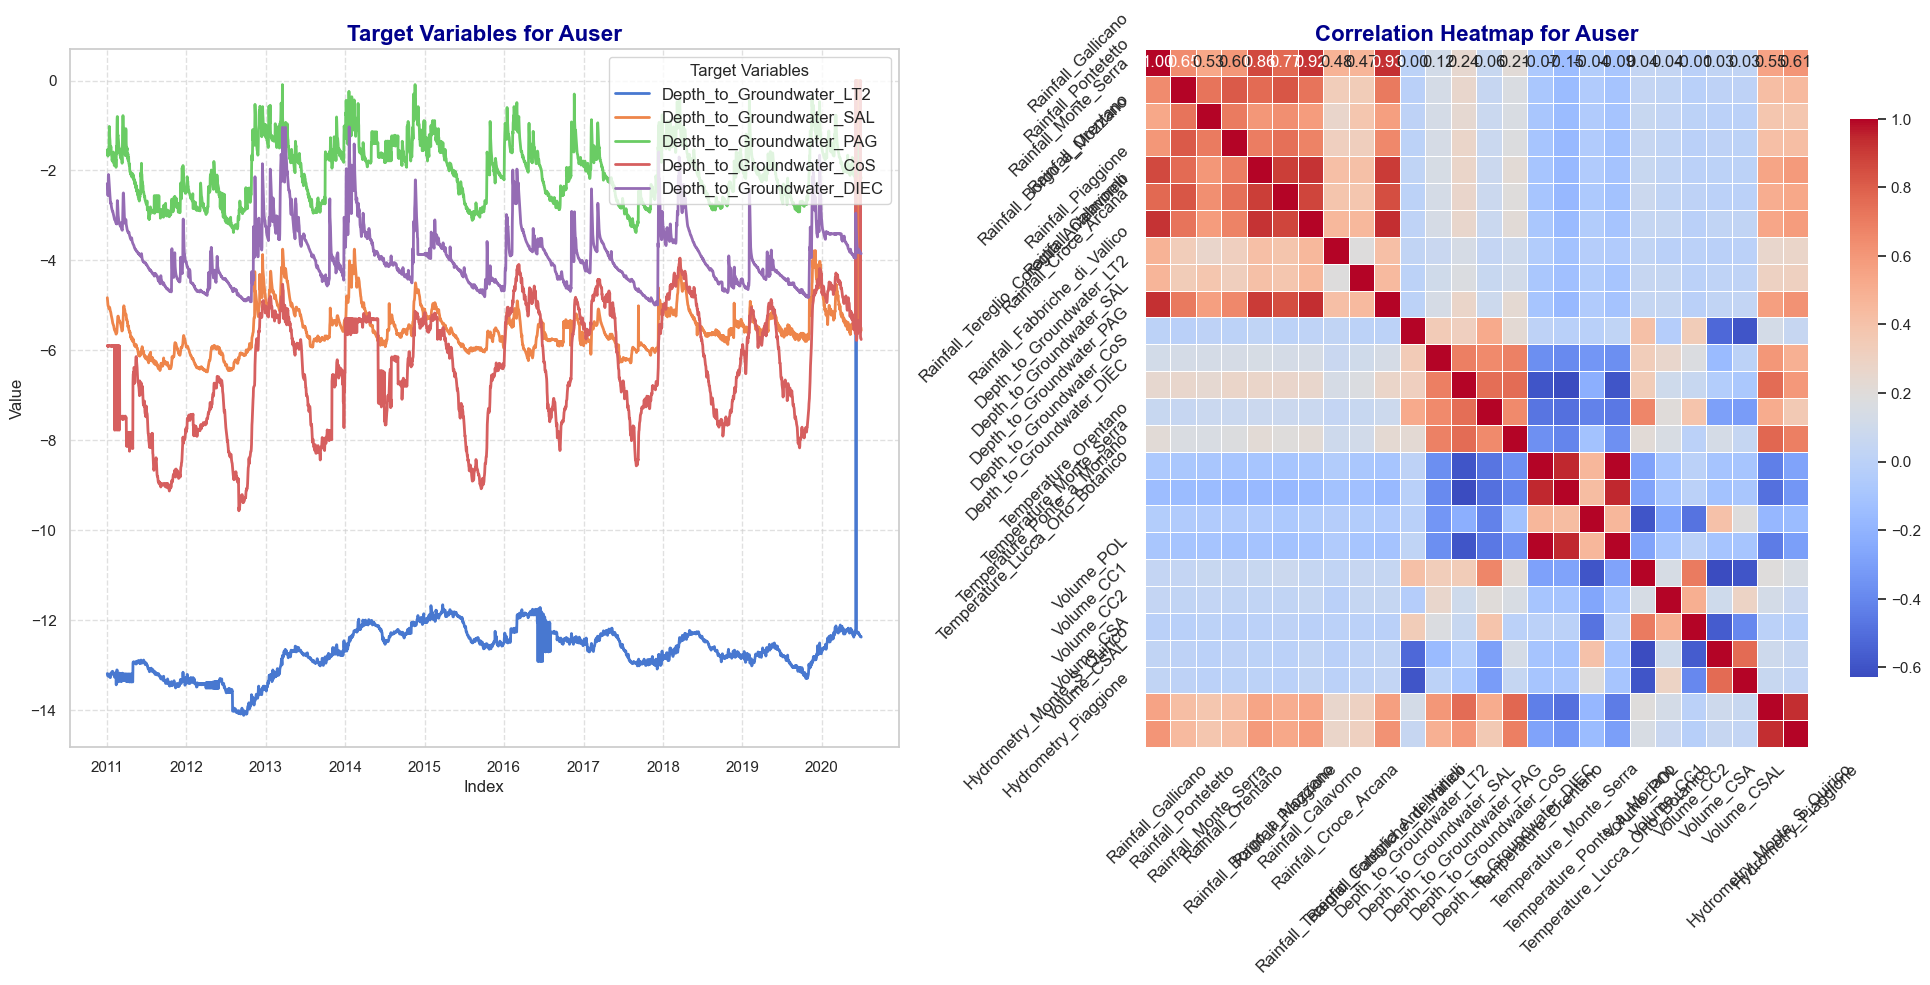

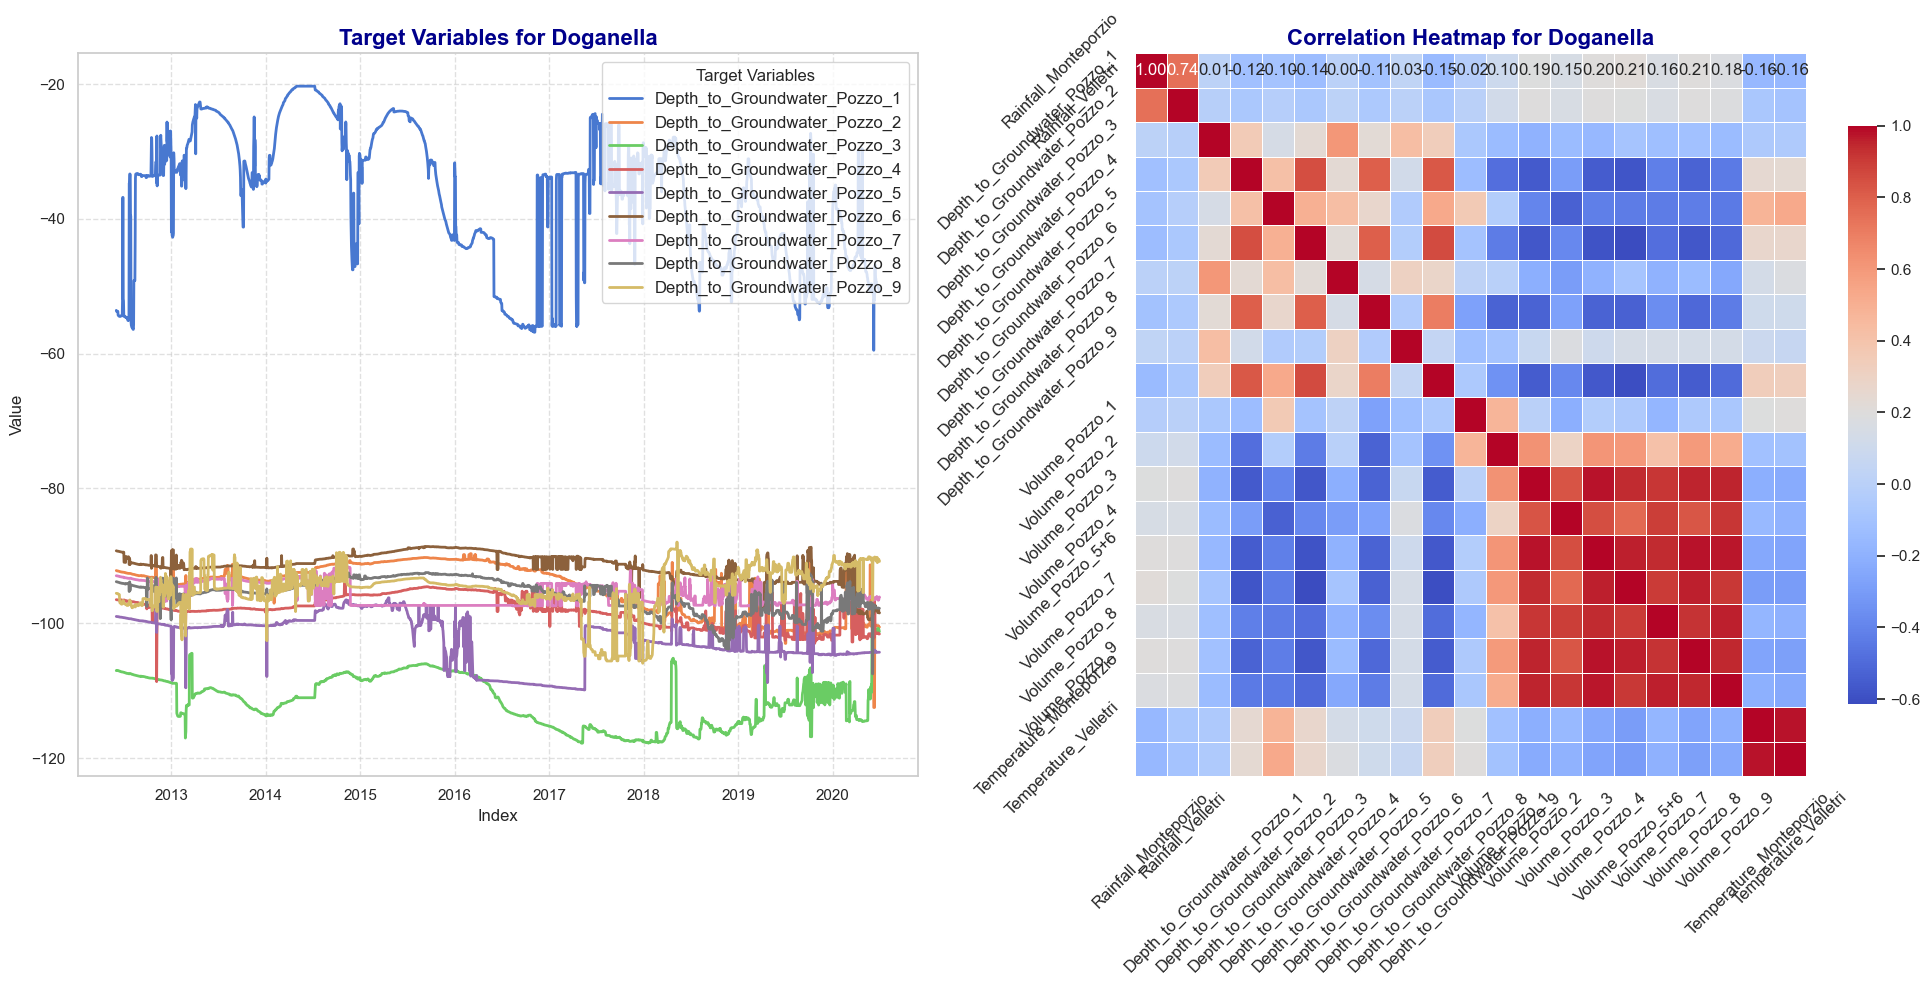

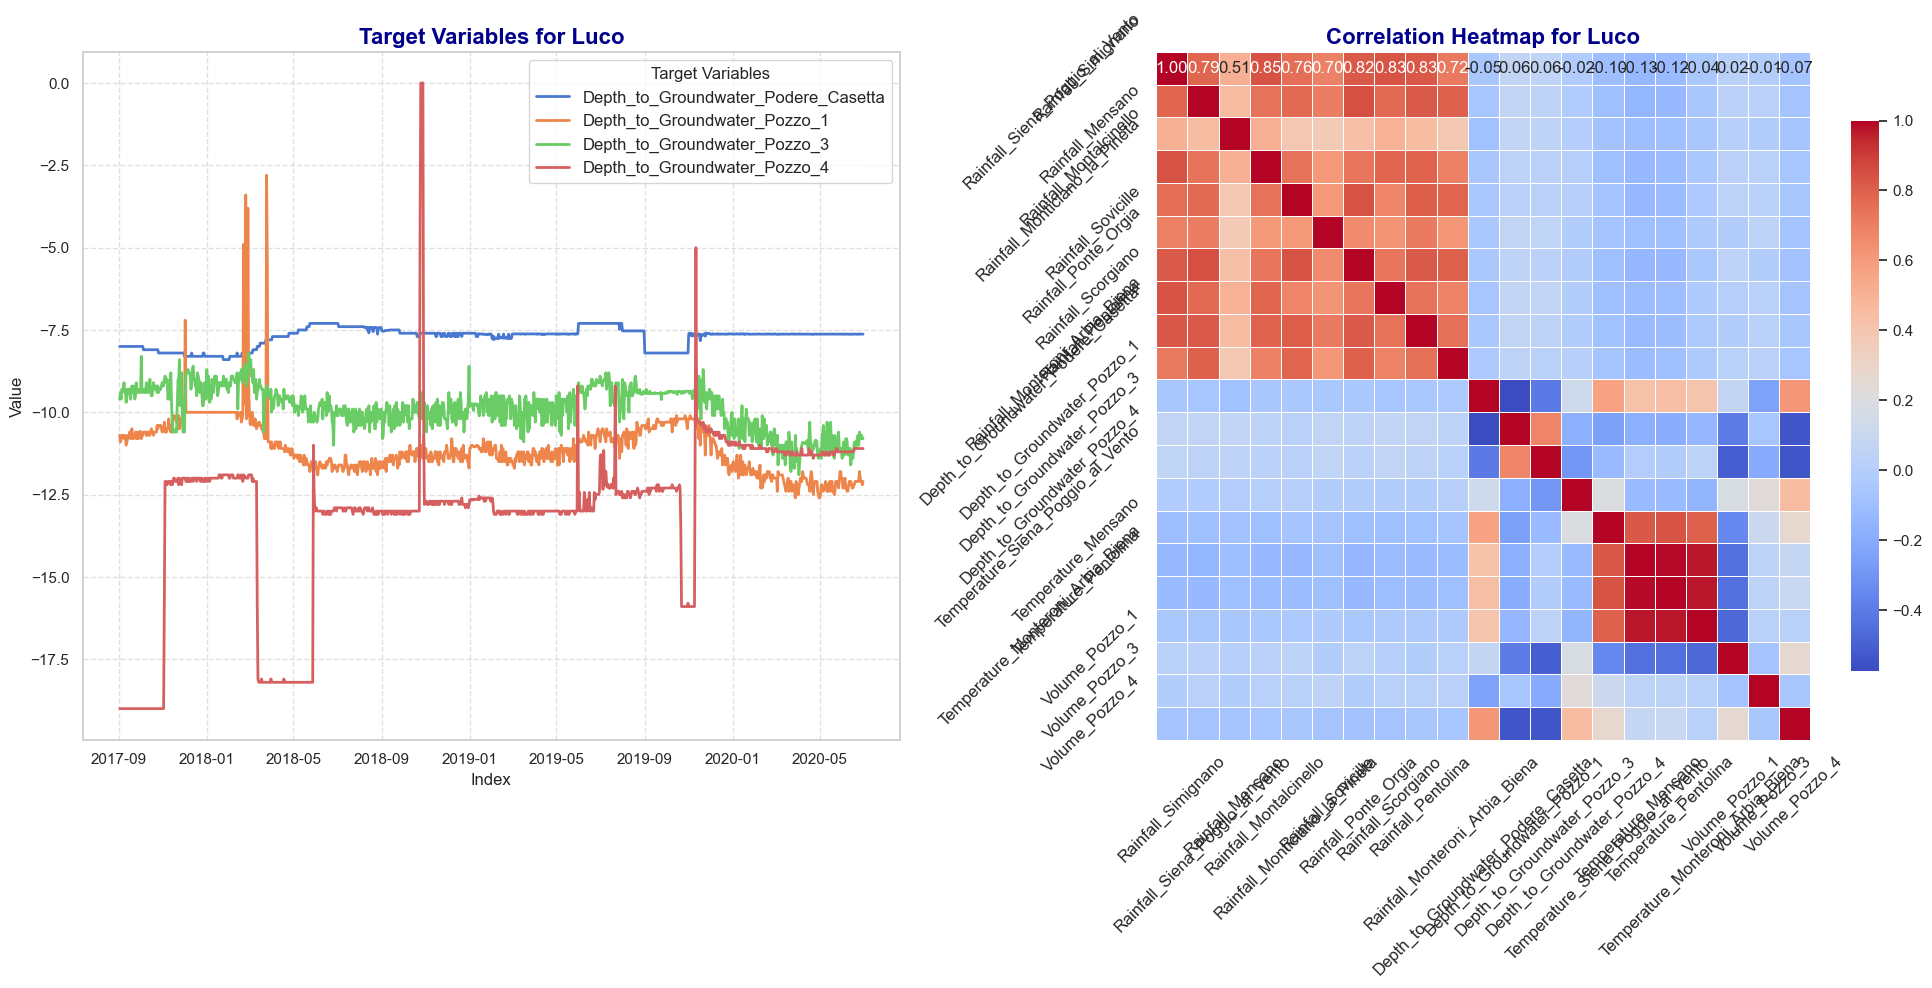

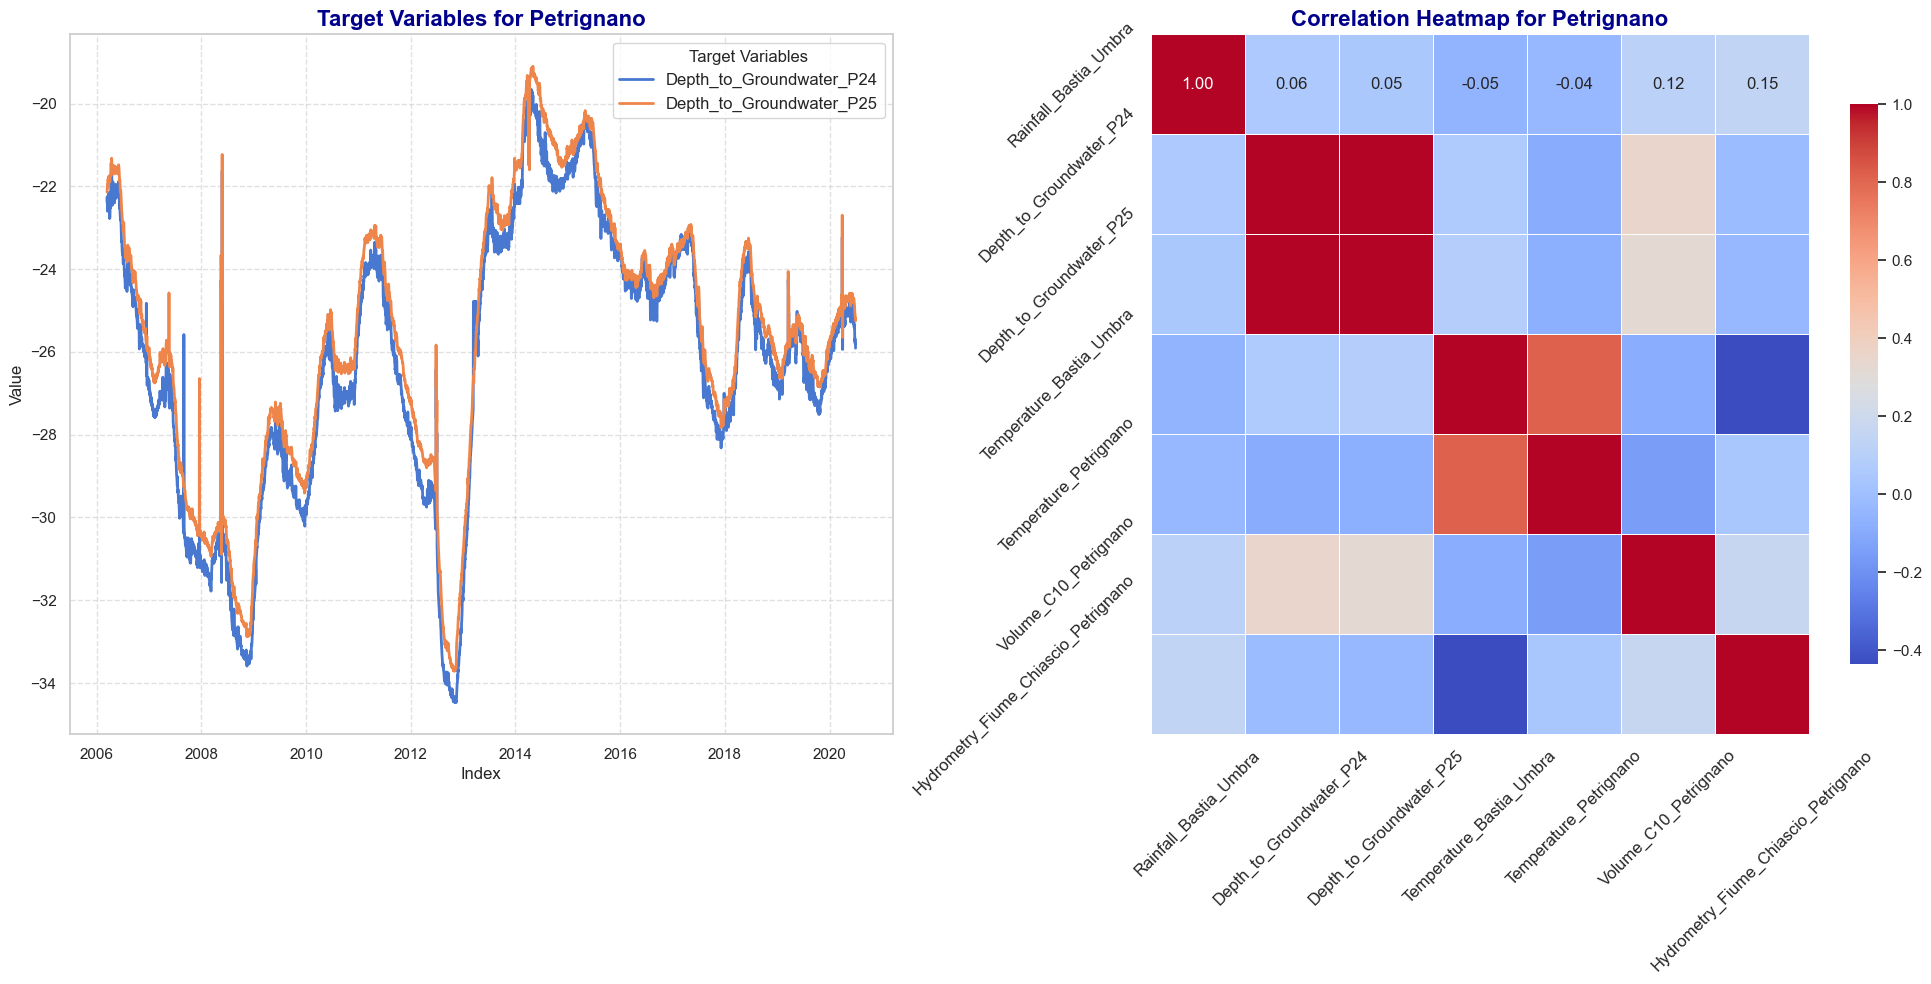

In [294]:

for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    EDA(df,'Depth',df_name = d).plot_target()

In [295]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df, best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = pd.concat([model_results, ModelEvaluation(X_test, y_test, d, comb[1], comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0], best_params).score_model()])
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Finished model Auser with shift period 1 and resampled frequency W
Finished model Auser with shift period 1 and resampled frequency M
Finished model Auser with shift period 1 and resampled frequency SM
Finished model Auser with shift period 2 and resampled frequency W
Finished model Auser with shift period 2 and resampled frequency M
Finished model Auser with shift period 2 and resampled frequency SM
Finished model Auser with shift period 3 and resampled frequency W
Finished model Auser with shift period 3 and resampled frequency M
Finished model Auser with shift period 3 and resampled frequency SM
Finished model Doganella with shift period 1 and resampled frequency W
Finished model Doganella with shift period 1 and resampled frequency M
Finished model Doganella with shift period 1 and resampled frequency SM
Finished model Doganella with shift period 2 and resampled frequency W
Finished model Doganella with shift period 2 and resampled frequency M
Finished model Doganella with shift pe

In [296]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])


Data Frequency Shift period  Mean squared error  Mean absolute error  \
0       Auser        SM            1            0.205833             0.323666   
0       Auser         W            1            0.218724             0.312277   
0       Auser         M            1            0.241545             0.368038   
0       Auser        SM            2            0.256465             0.357372   
0       Auser         W            2            0.257017             0.341190   
0       Auser         W            3            0.258995             0.347644   
0       Auser        SM            3            0.269876             0.364944   
0       Auser         M            2            0.291036             0.379211   
0       Auser         M            3            0.416380             0.428890   
0   Doganella         M            1           14.548504             2.736526   
0   Doganella        SM            1           15.455503             2.774236   
0   Doganella        SM            2           15.871387             2.824113   
0   Doganella         W            1           17.777358             2.872617   
0   Doganella        SM            3           17.979434             3.044007   
0   Doganella         W            3           17.983779             2.982292   
0   Doganella         M            3           18.375048             2.967777   
0   Doganella         W            2           18.732081             3.030312   
0   Doganella         M            2           19.743566             3.078505   
0        Luco         W            1            1.476797             0.993420   
0        Luco         M            1            1.480776             1.038841   
0        Luco        SM            1            1.552338             1.029106   
0        Luco         W            2            1.568879             1.010804   
0        Luco         M            3            1.650952             1.028573   
0        Luco         W            3            1.752614             1.068955   
0        Luco         M            2            1.968579             1.128921   
0        Luco        SM            3            1.990611             1.134973   
0        Luco        SM            2            2.011074             1.168313   
0  Petrignano         W            3            4.756940             1.913417   
0  Petrignano         M            3            5.164525             2.073218   
0  Petrignano         W            2            5.523777             2.081864   
0  Petrignano         W            1            5.544286             2.052489   
0  Petrignano        SM            1            6.033282             2.197646   
0  Petrignano         M            2            6.207827             2.218536   
0  Petrignano         M            1            6.226980             2.269618   
0  Petrignano        SM            3            6.250492             2.261628   
0  Petrignano        SM            2            6.322948             2.226615   

                                                                                                                                                                                                                                                                                                                                                                                                   Best parameters  
0   {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}  
0   {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_sample

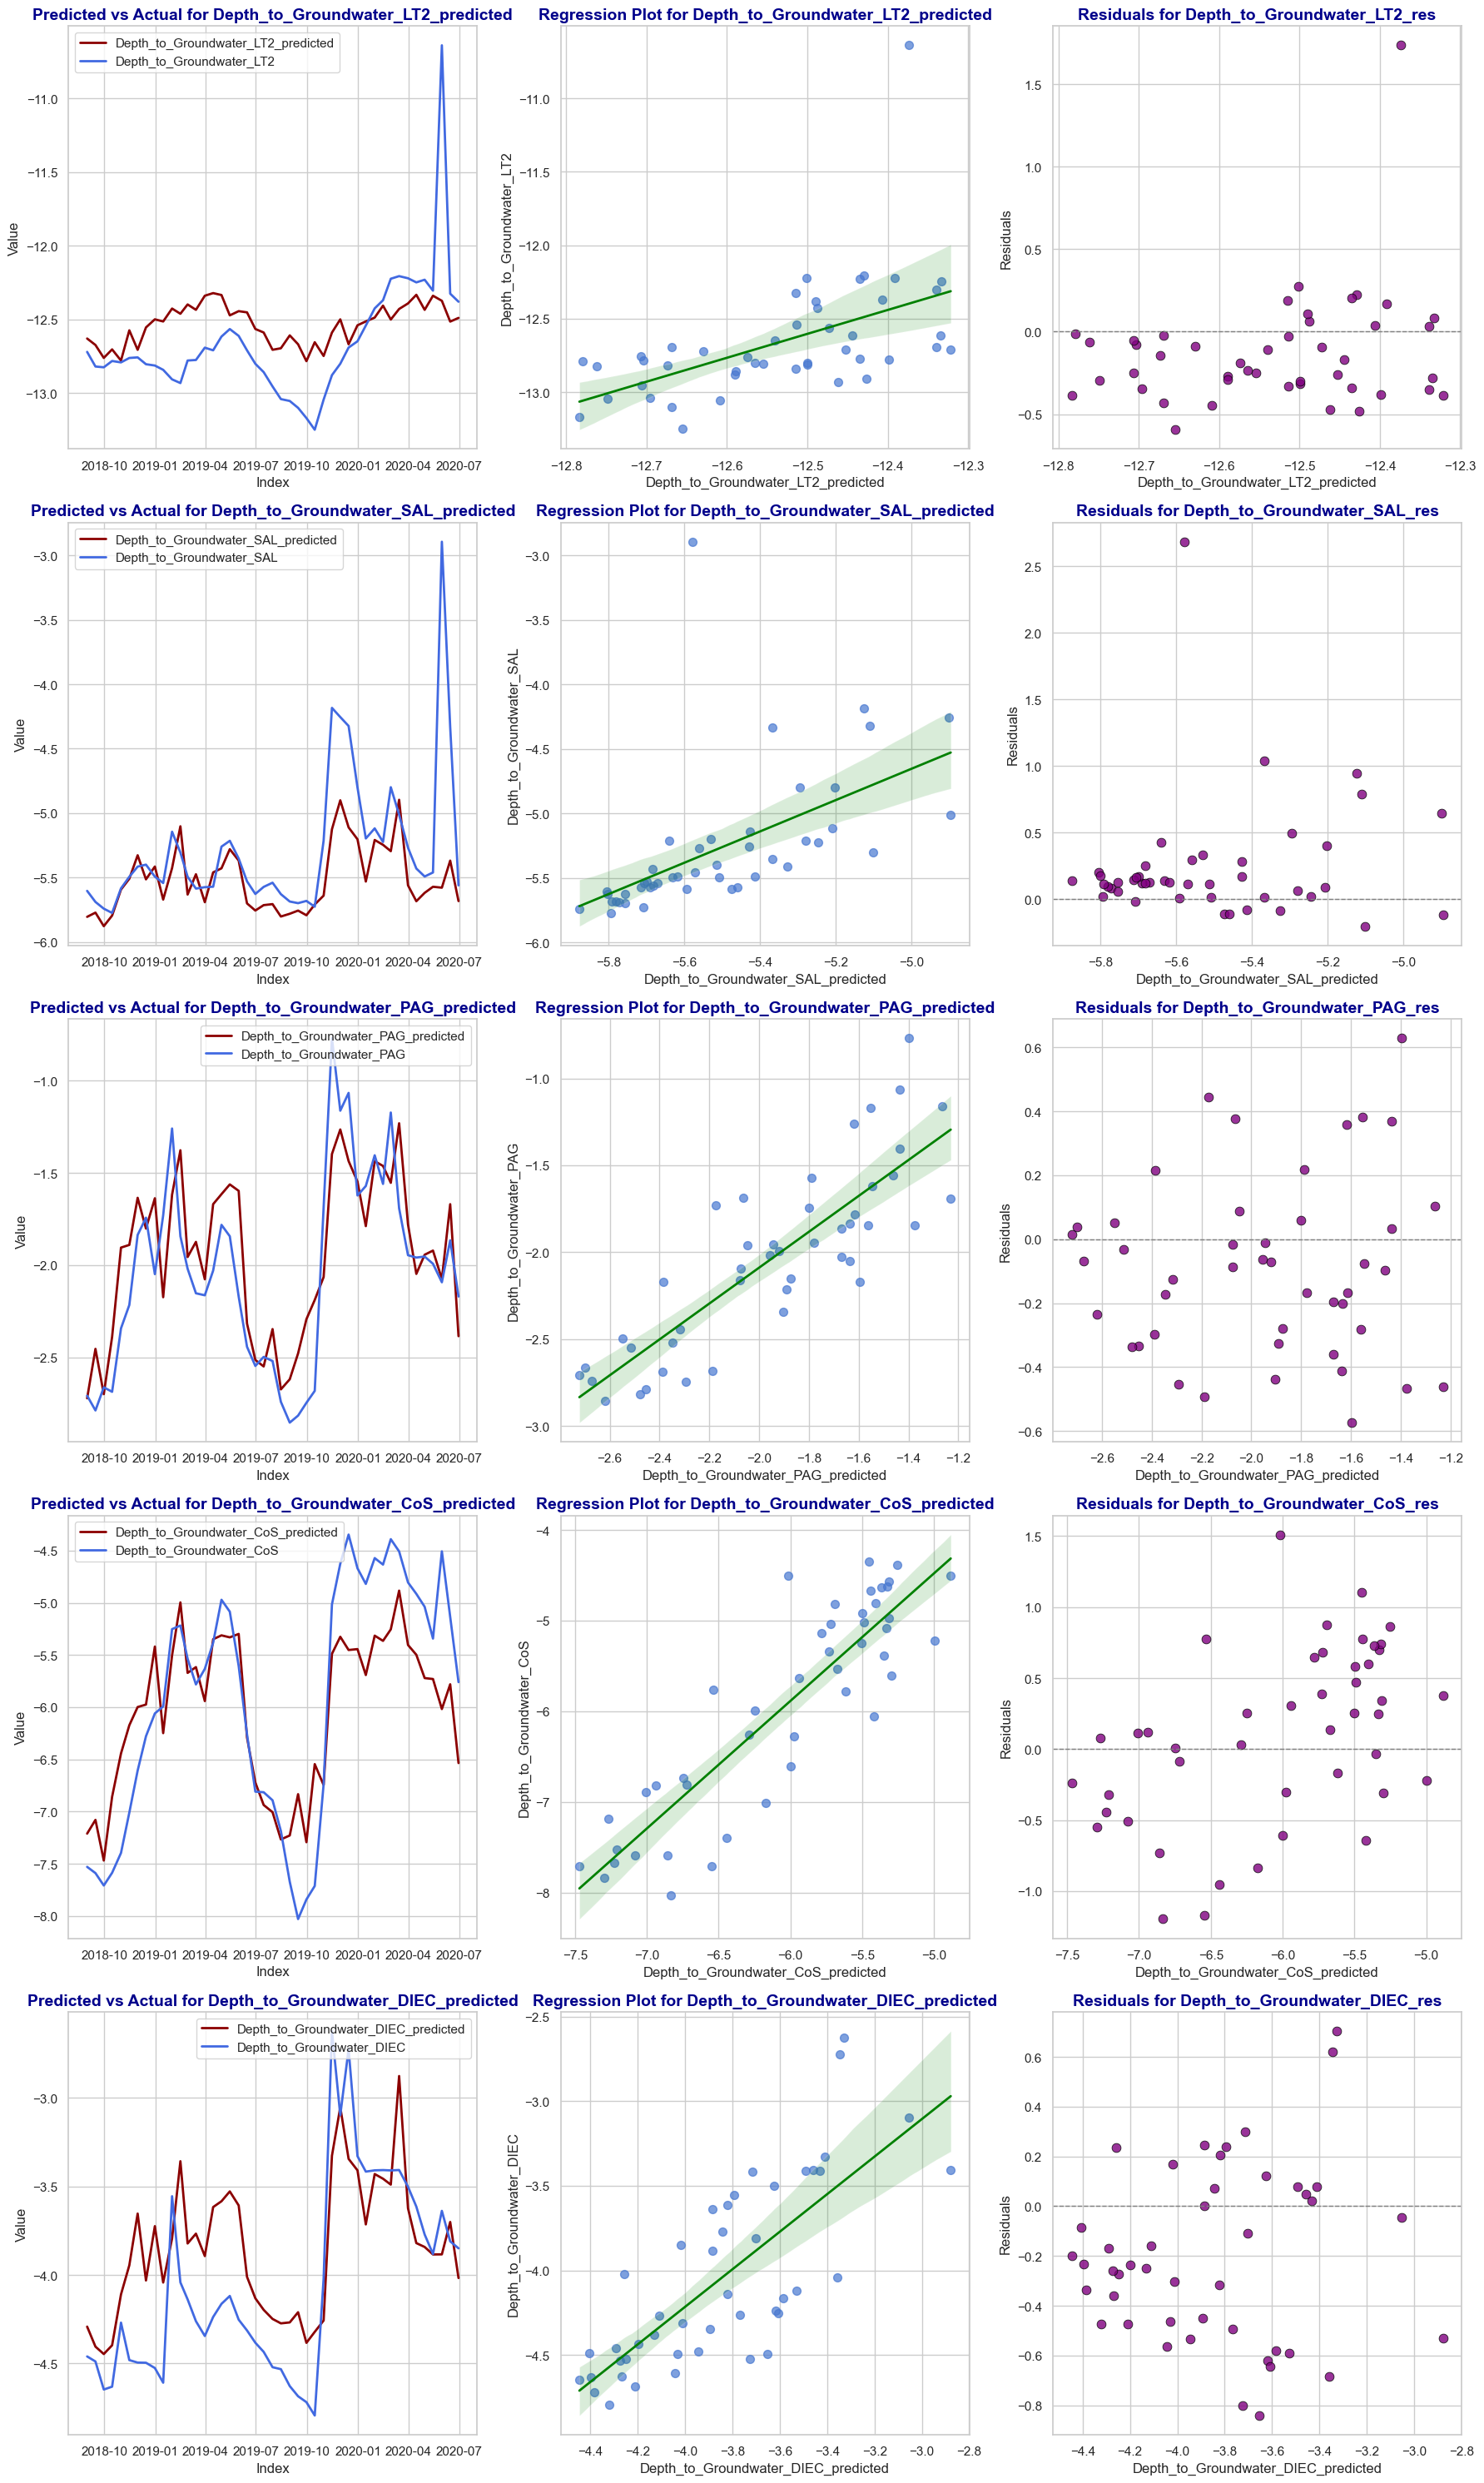

In [297]:
PlotResults(output_model['Auser_SM_1'][0], output_model['Auser_SM_1'][1],output_model['Auser_SM_1'][2],output_model['Auser_SM_1'][3]).plot_result()

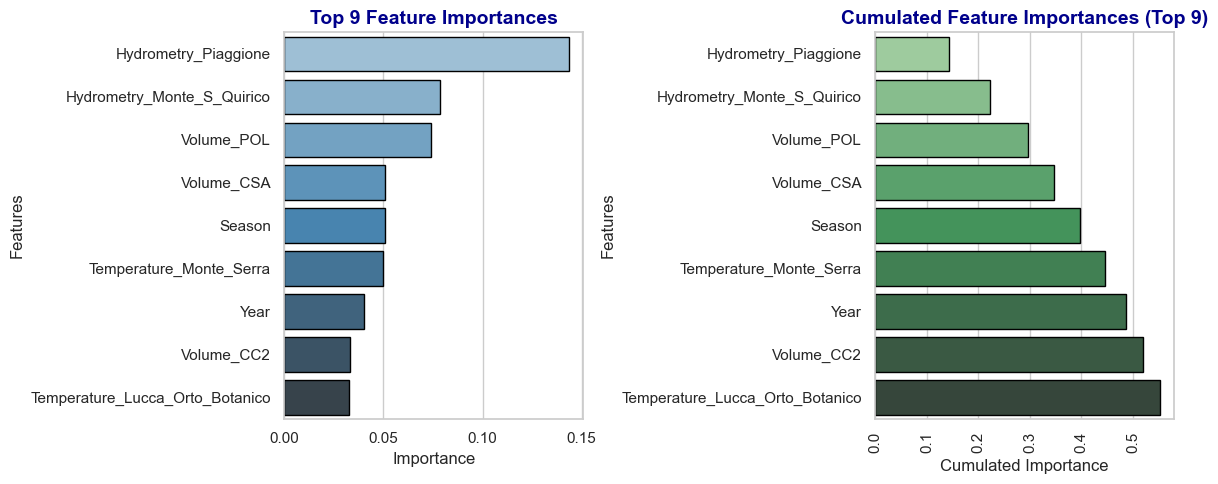

In [298]:
PlotResults(output_model['Auser_SM_1'][0], output_model['Auser_SM_1'][1],output_model['Auser_SM_1'][2],output_model['Auser_SM_1'][3]).plot_importances(9,figure_width=12,figure_height =5)

In [299]:
Statistics(output_model['Auser_SM_1'][2]).statistics()


Target       Shapiro      Mean  Variance  Skewness  \
0   Depth_to_Groundwater_LT2_res  4.899081e-08 -0.124738  0.126360  3.218844   
1   Depth_to_Groundwater_SAL_res  7.016036e-10  0.235154  0.206657  3.773744   
2   Depth_to_Groundwater_PAG_res  2.318340e-01 -0.087178  0.078986  0.488829   
3   Depth_to_Groundwater_CoS_res  8.278597e-01  0.097951  0.382248 -0.154948   
4  Depth_to_Groundwater_DIEC_res  4.208411e-01 -0.198552  0.127934  0.400145   

    Kurtosis  Standard_deviation  Standard_error_mean  R2_Score  
0  14.714665            0.355472             0.052991  0.663920  
1  17.041820            0.454595             0.067767  0.646540  
2  -0.277046            0.281045             0.041896  0.611994  
3  -0.477583            0.618262             0.092165  0.607474  
4  -0.289838            0.357679             0.053320  0.602280

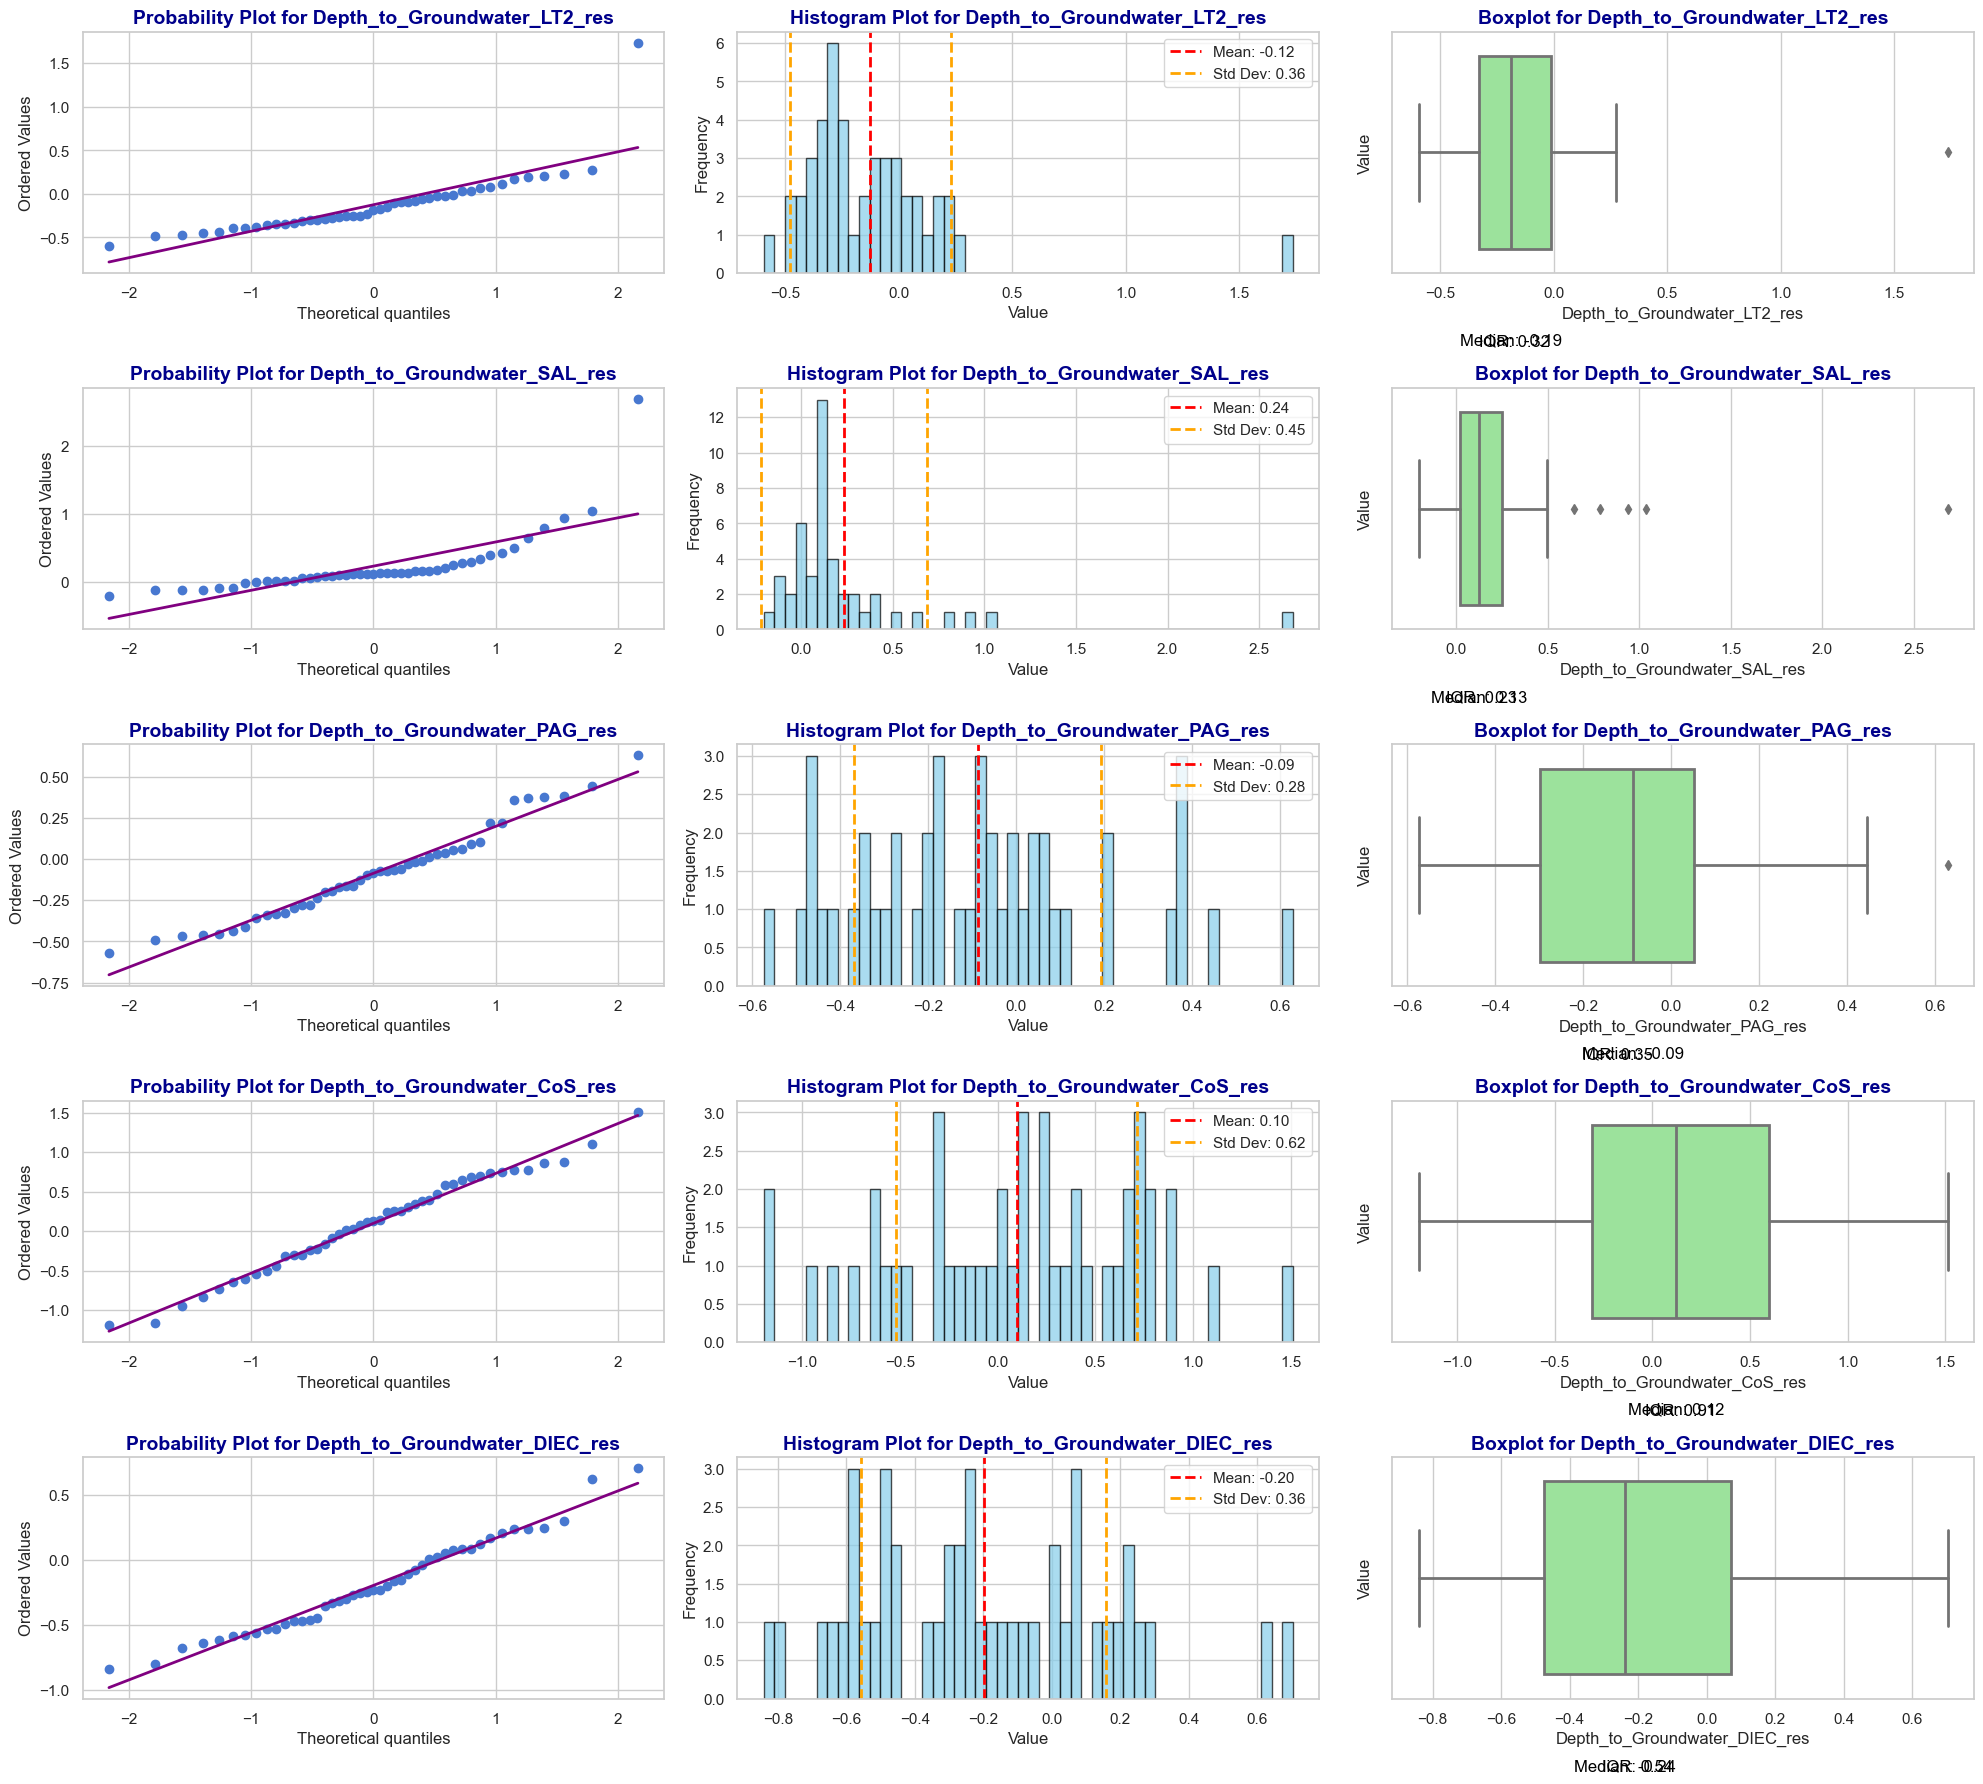

In [300]:
Statistics(output_model['Auser_SM_1'][2]).plot_stat()


In [301]:
### LINEAR REGRESSION  ###

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd

class Model():
    """
    This is the class that models the data. A pipeline is created to model data. The pipeline is encapsulated in a
    RandomizedSearchCV to allow flexibility in tuning the LinearRegression model (although in practice LinearRegression 
    has fewer hyperparameters to tune).
    The output is a dataframe with predicted values, residuals, coefficients, and best parameters for the model.
    """
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def model(self):
        # Pipeline with RobustScaler and LinearRegression
        pipe = Pipeline([('scaler', RobustScaler()), ('lr', LinearRegression())])

        # LinearRegression has fewer hyperparameters, so we will only tune the regularization strength (if using Ridge or Lasso) 
        # or leave it as is for basic LinearRegression.
        param_grid = {
            # For LinearRegression, we might add some parameters like fit_intercept and normalize, 
            # but here we'll just use the default LinearRegression without tuning specific parameters.
            'lr__fit_intercept': [True, False]
        }

        # Using RandomizedSearchCV for hyperparameter tuning (even though it may not yield a major effect on LinearRegression)
        gs = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=20, n_jobs=2, verbose=0, random_state=0)

        # Fit the RandomizedSearchCV with the training data
        search = gs.fit(self.X_train, self.y_train)

        # Get the best parameters from the search
        best_params = search.best_estimator_.named_steps['lr'].get_params()

        # Get the coefficients of the model (important for linear regression interpretation)
        coefficients = search.best_estimator_.named_steps['lr'].coef_

        # If y_train has multiple targets, the coefficients will be 2D
        # The shape of coefficients will be (n_targets, n_features)
        
        # Create a DataFrame for coefficients for each target
        if coefficients.ndim == 2:
            # Reshape coefficients and create a DataFrame with targets as columns and features as rows
            coefficients_df = pd.DataFrame(coefficients.T, columns=self.y_train.columns, index=self.X_train.columns)
        else:
            # If there's only one target, simply create a DataFrame with the coefficients
            coefficients_df = pd.DataFrame(coefficients, index=self.X_train.columns, columns=['Coefficient'])

        # Sort the coefficients based on their absolute values, either for each target or for a single target
        if coefficients_df.shape[1] > 1:
            # Multi-output regression case: sort by absolute values across each target
            coefficients_df = coefficients_df.abs().apply(lambda x: x.sort_values(ascending=False).index, axis=0)
        else:
            # Single target regression case: sort by the absolute value of coefficients
            coefficients_df = coefficients_df.abs().sort_values(by='Coefficient', ascending=False)

        # Predict values using the best estimator from the RandomizedSearchCV
        predicted = pd.DataFrame(search.predict(self.X_test), columns=[f'{col}_predicted' for col in self.y_test.columns], index=self.X_test.index)

        # Calculate residuals (difference between actual and predicted values)
        residuals = self.y_test - predicted.values
        residuals_df = residuals.copy()

        # Renaming residuals columns for clarity
        for col in residuals_df.columns:
            residuals_df.rename(columns={col: f'{col}_res'}, inplace=True)

        # Return the predicted values, residuals, coefficients, and best parameters
        return predicted, residuals_df, coefficients_df, best_params


In [302]:
for d in data_input:
    df = DataPreparation(data_input[d][1]).transform(data_input[d][0])
    for comb in combinations:
        df_model =  FeatureEngineering(target= data_input[d][1],shift_period = comb[0], resampled_freq = comb[1]).transform(df)
        X_train, y_train, X_test, y_test = TrainTestSplit(df_model,target =data_input[d][1]).split()
        predicted_df, residuals_df, importances_df, best_params= Model(X_train, y_train,X_test, y_test).model()
        output_model[f"{d}_{comb[1]}_{comb[0]}"] = [predicted_df, y_test,residuals_df,importances_df, best_params] 
        model_results = pd.concat([model_results, ModelEvaluation(X_test, y_test, d, comb[1], comb[0], output_model[f"{d}_{comb[1]}_{comb[0]}"][0], best_params).score_model()])
        print(f"Finished model {d} with shift period {comb[0]} and resampled frequency {comb[1]}")

Finished model Auser with shift period 1 and resampled frequency W
Finished model Auser with shift period 1 and resampled frequency M
Finished model Auser with shift period 1 and resampled frequency SM
Finished model Auser with shift period 2 and resampled frequency W
Finished model Auser with shift period 2 and resampled frequency M
Finished model Auser with shift period 2 and resampled frequency SM
Finished model Auser with shift period 3 and resampled frequency W
Finished model Auser with shift period 3 and resampled frequency M
Finished model Auser with shift period 3 and resampled frequency SM
Finished model Doganella with shift period 1 and resampled frequency W
Finished model Doganella with shift period 1 and resampled frequency M
Finished model Doganella with shift period 1 and resampled frequency SM
Finished model Doganella with shift period 2 and resampled frequency W
Finished model Doganella with shift period 2 and resampled frequency M
Finished model Doganella with shift pe

In [303]:
model_results.sort_values(by = ['Data','Mean squared error', 'Mean absolute error'])

Data Frequency Shift period  Mean squared error  Mean absolute error  \
0       Auser        SM            1            0.205833             0.323666   
0       Auser         W            1            0.218724             0.312277   
0       Auser         M            1            0.241545             0.368038   
0       Auser        SM            2            0.256465             0.357372   
0       Auser         W            2            0.257017             0.341190   
0       Auser         W            3            0.258995             0.347644   
0       Auser        SM            3            0.269876             0.364944   
0       Auser         M            2            0.291036             0.379211   
0       Auser         M            3            0.416380             0.428890   
0       Auser         M            1            0.576774             0.536468   
0       Auser        SM            2            0.592207             0.542931   
0       Auser        SM            1            0.641544             0.561629   
0       Auser         W            1            0.677150             0.564685   
0       Auser         W            2            0.767244             0.600372   
0       Auser        SM            3            0.798148             0.629540   
0       Auser         W            3            0.858224             0.630885   
0       Auser         M            2            1.589776             0.913163   
0       Auser         M            3            4.191785             1.408383   
0   Doganella         M            1           14.548504             2.736526   
0   Doganella        SM            1           15.455503             2.774236   
0   Doganella        SM            2           15.871387             2.824113   
0   Doganella         W            1           17.600631             3.087706   
0   Doganella         W            1           17.777358             2.872617   
0   Doganella        SM            3           17.979434             3.044007   
0   Doganella         W            3           17.983779             2.982292   
0   Doganella         M            3           18.375048             2.967777   
0   Doganella         W            2           18.732081             3.030312   
0   Doganella        SM            1           19.312144             3.152754   
0   Doganella         W            2           19.510101             3.110946   
0   Doganella         M            2           19.743566             3.078505   
0   Doganella         W            3           20.064754             3.247565   
0   Doganella         M            1           22.257073             3.137388   
0   Doganella        SM            2           22.463498             3.406420   
0   Doganella         M            2           35.685862             4.079212   
0   Doganella        SM            3           46.254876             4.330655   
0   Doganella         M            3           72.712673             5.152304   
0        Luco        SM            1            0.976106             0.709982   
0        Luco         W            1            1.017761             0.733621   
0        Luco         M            3            1.446439             0.966053   
0        Luco         W            2            1.473386             0.819612   
0        Luco         W            1            1.476797             0.993420   
0        Luco         M            1            1.480776             1.038841   
0        Luco        SM            1            1.552338             1.029106   
0        Luco         W            2            1.568879             1.010804   
0        Luco         M            3            1.650952             1.028573   
0        Luco         W            3            1.752614             1.068955   
0        Luco         M            2            1.968579             1.128921   
0        Luco        SM            3            1.990611             1.134973   
0        Luco        SM            2    

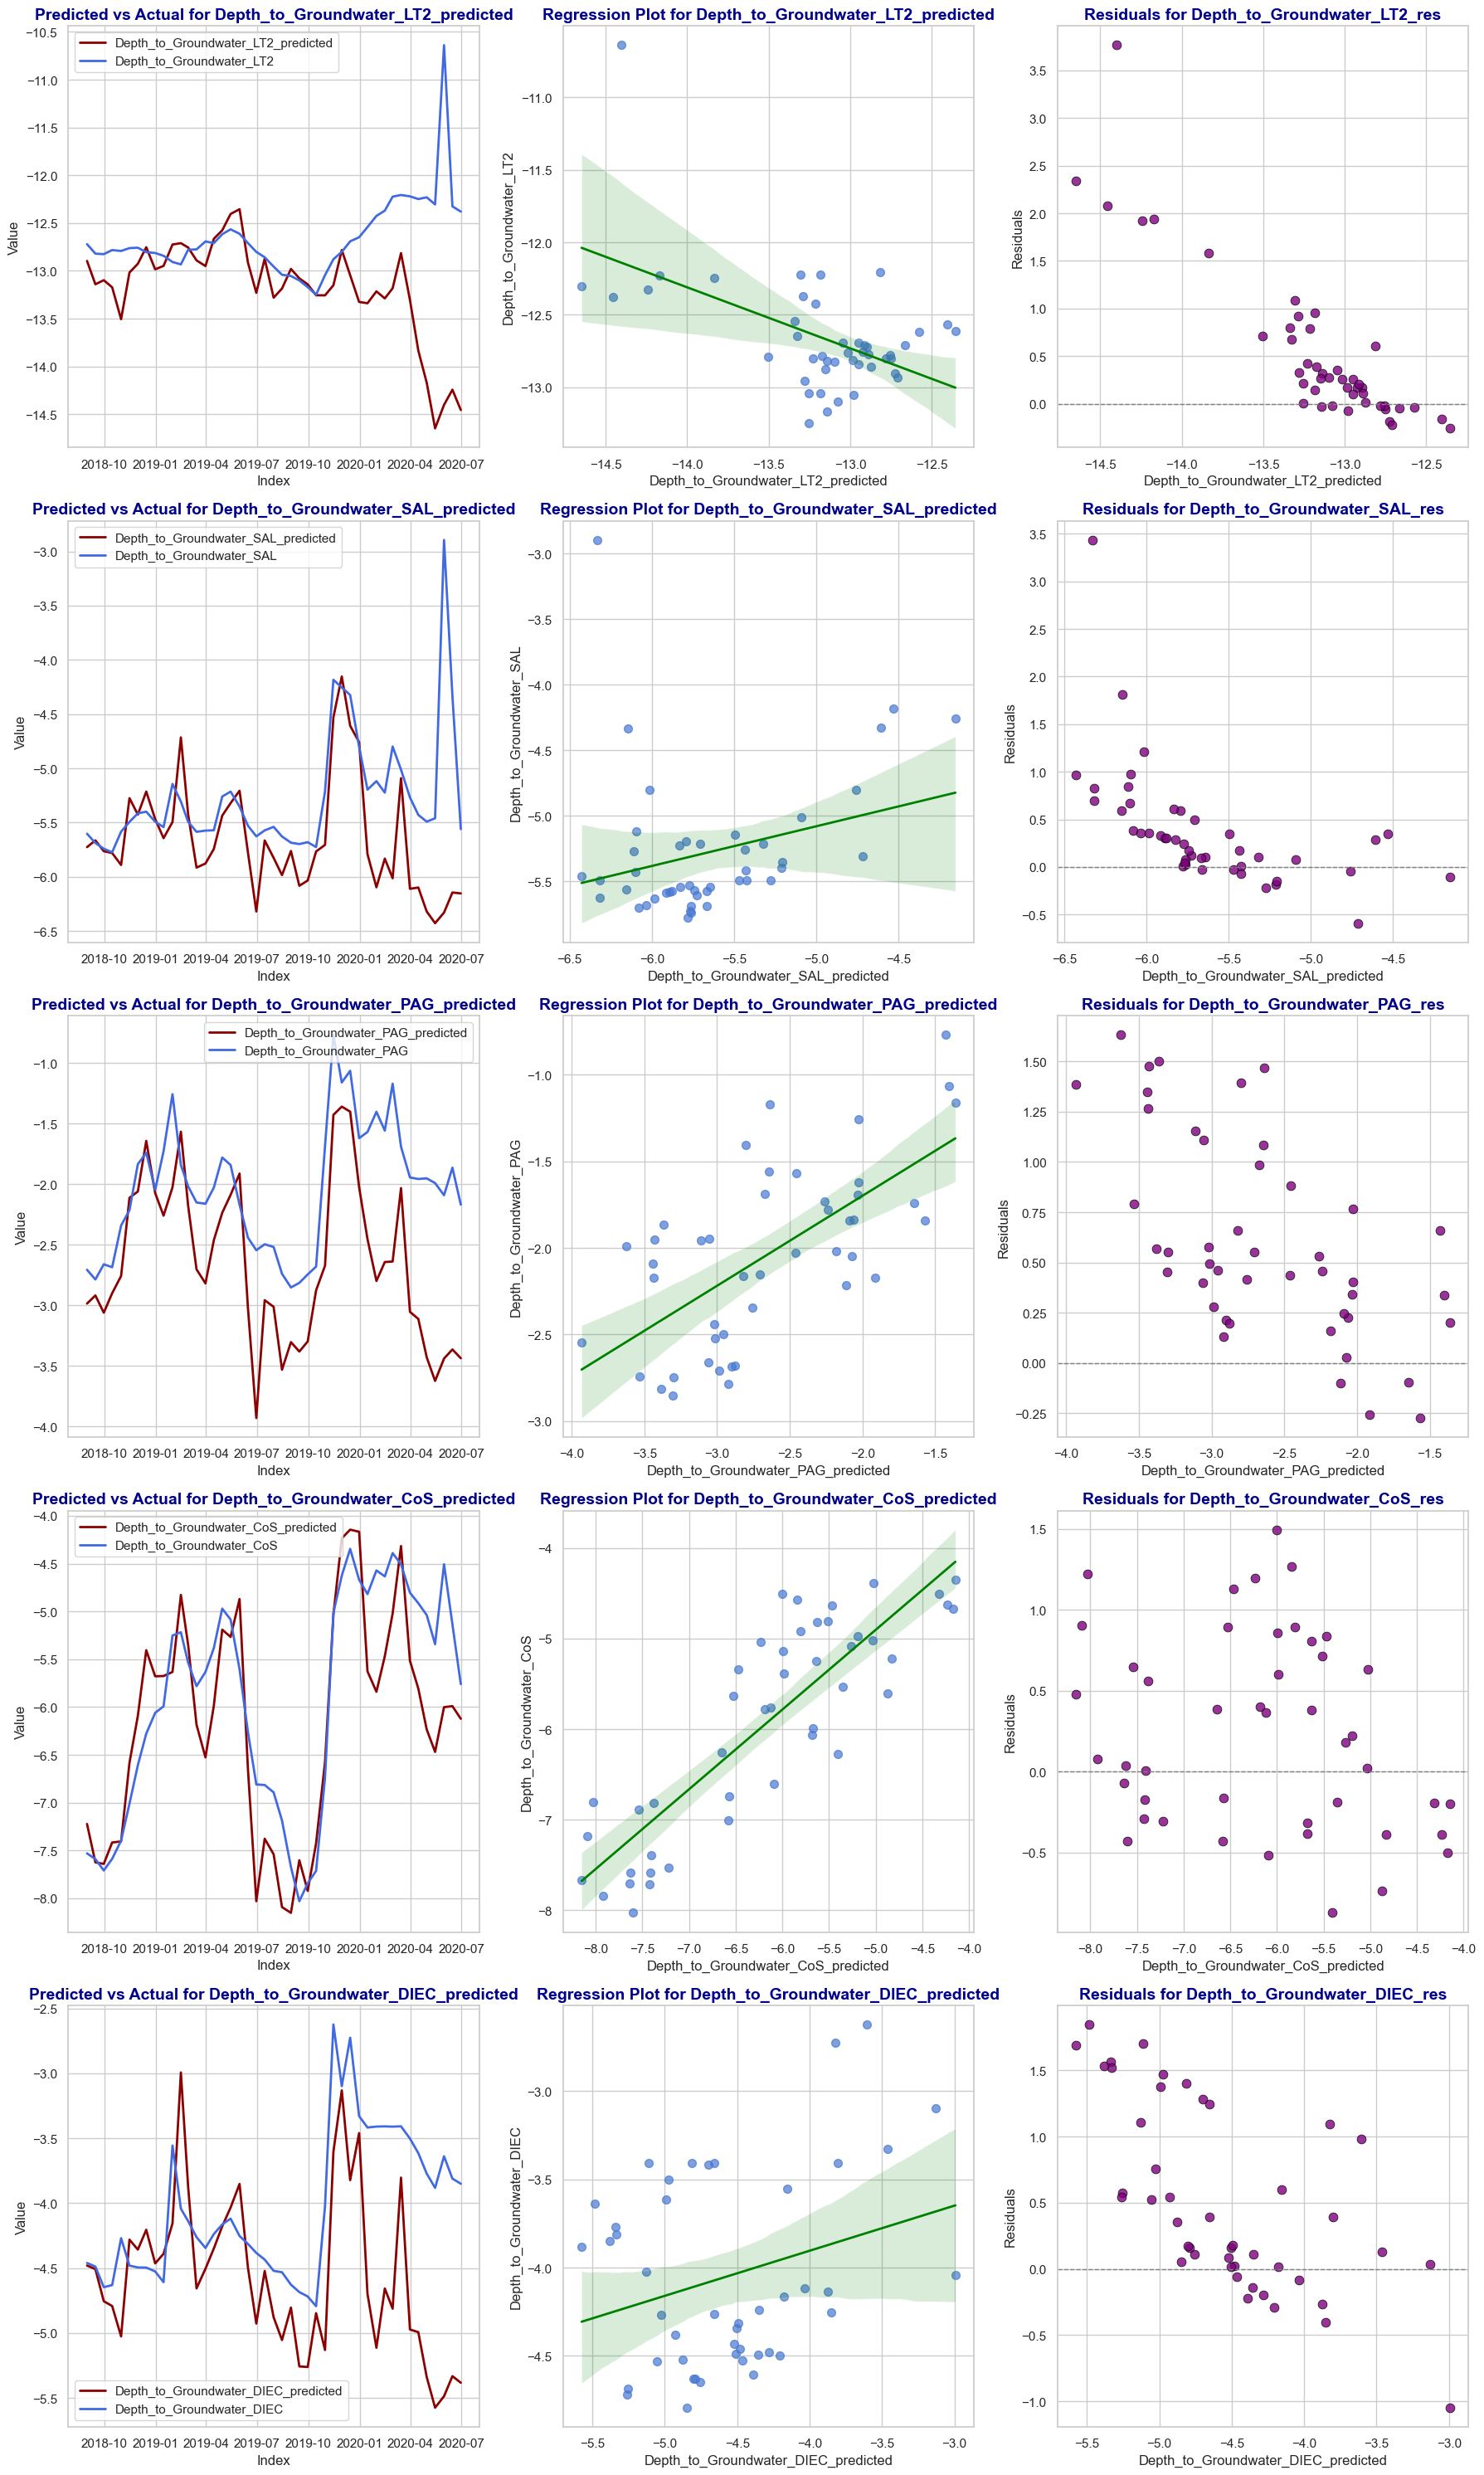

In [304]:
PlotResults(output_model['Auser_SM_1'][0], output_model['Auser_SM_1'][1],output_model['Auser_SM_1'][2],output_model['Auser_SM_1'][3]).plot_result()

In [305]:
Statistics(output_model['Auser_SM_1'][2]).statistics()

Target       Shapiro      Mean  Variance  Skewness  \
0   Depth_to_Groundwater_LT2_res  3.240311e-07  0.516353  0.654875  2.072372   
1   Depth_to_Groundwater_SAL_res  1.534517e-07  0.375253  0.397947  2.816784   
2   Depth_to_Groundwater_PAG_res  4.355300e-02  0.611116  0.254033  0.404571   
3   Depth_to_Groundwater_CoS_res  1.620280e-01  0.236989  0.363674  0.222787   
4  Depth_to_Groundwater_DIEC_res  1.438974e-02  0.512455  0.485430  0.312102   

    Kurtosis  Standard_deviation  Standard_error_mean  R2_Score  
0   4.579202            0.809244             0.120635  0.747627  
1  10.829888            0.630831             0.094039  0.776099  
2  -0.722000            0.504017             0.075134  0.879276  
3  -0.989430            0.603054             0.089898  0.711879  
4  -0.804389            0.696728             0.103862  0.843491

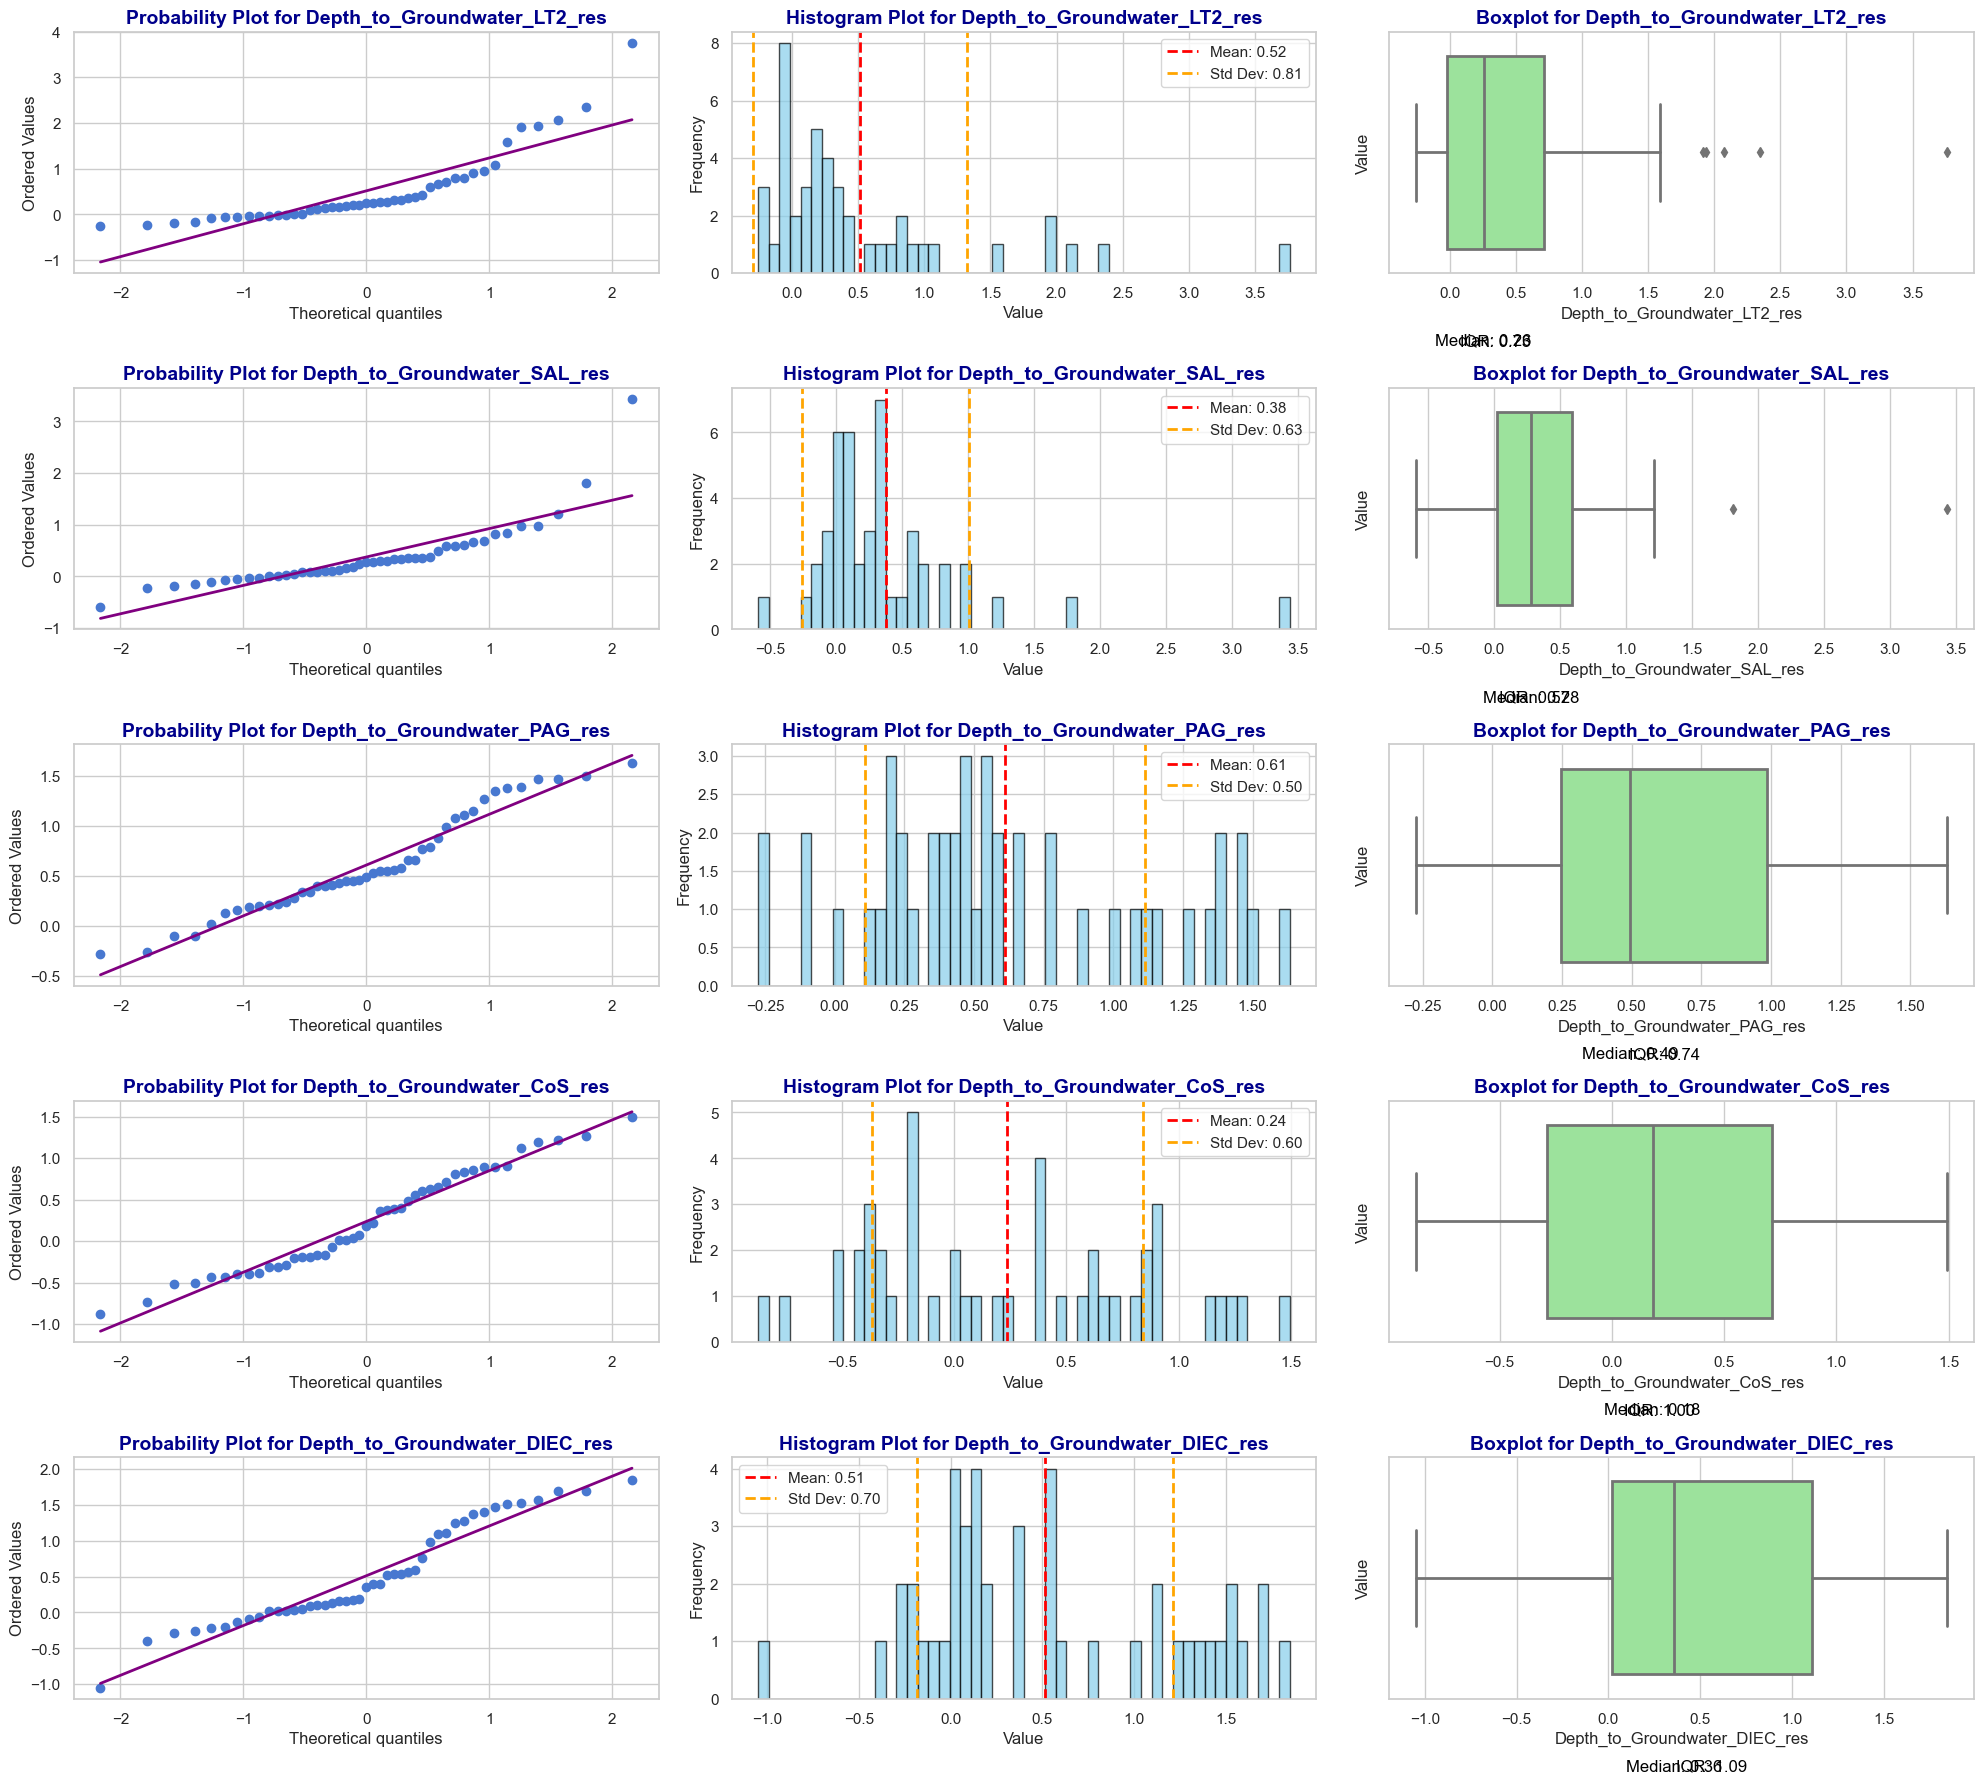

In [306]:
Statistics(output_model['Auser_SM_1'][2]).plot_stat()
